In [1]:
from helpers import *
from environments import *
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.api._v2.keras as K
input_ = K.layers.Input(shape=(BaseEnvironment.BOARD_SIZE, BaseEnvironment.BOARD_SIZE, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input_)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

encoder = K.Model(inputs=[input_], outputs=[x])
policy = K.layers.Flatten()(encoder.output)
policy = K.layers.Dense(128, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(128, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=encoder.output, outputs=policy)

vf = K.layers.Flatten()(encoder.output)
vf = K.layers.Dense(128, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(128, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(4, activation=tf.nn.softmax)(vf)
value = K.models.Model(inputs=encoder.output, outputs=vf)


dec = K.layers.SpatialDropout2D(.4)(encoder.output)
dec = K.layers.Conv2DTranspose(32, 5, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.SpatialDropout2D(.4)(dec)
dec = K.layers.Conv2DTranspose(32, 5, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.SpatialDropout2D(.4)(dec)
dec = K.layers.Conv2DTranspose(5, 5, activation=tf.nn.softmax)(dec)
decoder = K.models.Model(inputs=encoder.output, outputs=dec)

Metal device set to: Apple M1 Max


2022-12-29 23:06:59.080028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 23:06:59.080143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [75]:
def re_normalize_possible_actions_process_npi(state, probs, mask_with=0.):
    global walls, heads_up
    boards = tf.argmax(state, axis=-1)
    heads = np.argwhere(boards == BaseEnvironment.HEAD)
    walls = np.argwhere(boards == BaseEnvironment.WALL)
    mask = np.ones_like(probs)

    heads_up = np.copy(heads)
    heads_down = np.copy(heads)
    heads_left = np.copy(heads)
    heads_right = np.copy(heads)

    heads_up[:, 1] += 1
    heads_down[:, 1] -= 1
    heads_left[:, 2] += 1
    heads_right[:, 2] -= 1

    inds = heads_up == walls[:, None]
    row_sums = inds.sum(axis = 2)
    i, j = np.where(row_sums == 3)
    pos = np.ones(walls.shape[0], dtype = 'int64') * -1
    pos[j] = i
    idx_up = pos[np.argwhere(pos>=0)].reshape((-1,))

    inds = heads_down == walls[:, None]
    row_sums = inds.sum(axis = 2)
    i, j = np.where(row_sums == 3)
    pos = np.ones(walls.shape[0], dtype = 'int64') * -1
    pos[j] = i
    idx_down = pos[np.argwhere(pos>=0)].reshape((-1,))

    inds = heads_left == walls[:, None]
    row_sums = inds.sum(axis = 2)
    i, j = np.where(row_sums == 3)
    pos = np.ones(walls.shape[0], dtype = 'int64') * -1
    pos[j] = i
    idx_left = pos[np.argwhere(pos>=0)].reshape((-1,))

    inds = heads_right == walls[:, None]
    row_sums = inds.sum(axis = 2)
    i, j = np.where(row_sums == 3)
    pos = np.ones(walls.shape[0], dtype = 'int64') * -1
    pos[j] = i
    idx_right = pos[np.argwhere(pos>=0)].reshape((-1,))

    idx_up = walls[idx_up][:,0]
    idx_down = walls[idx_down][:,0]
    idx_right = walls[idx_right][:,0]
    idx_left = walls[idx_left][:,0]

    if np.size(idx_up): mask[idx_up, BaseEnvironment.UP] = mask_with
    if np.size(idx_down): mask[idx_down, BaseEnvironment.DOWN] = mask_with
    if np.size(idx_right): mask[idx_right, BaseEnvironment.LEFT] = mask_with
    if np.size(idx_left): mask[idx_left, BaseEnvironment.RIGHT] = mask_with

    return tf.linalg.normalize(probs * mask, ord=1, axis=-1)[0]

In [63]:
%matplotlib inline
np.random.seed(7)
test_env = NumpyEnvironment(2)

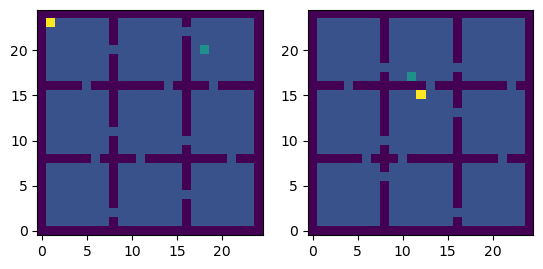

In [64]:
fig, axs = plt.subplots(1,2)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))

yep


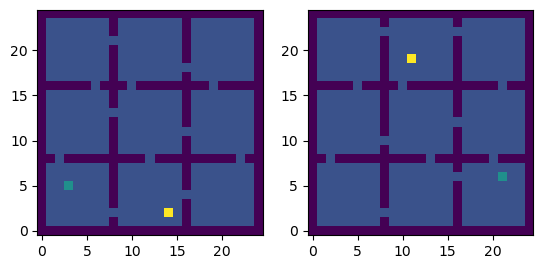

In [8]:
state = test_env.to_state()
compressed_state = encoder(state)

original_probs = agent(
    compressed_state
)
probs = re_normalize_possible_actions_process_npi(
    state,
    original_probs
)
actions = tf.random.categorical(tf.math.log(probs),1)
test_env.move(actions)
fig, axs = plt.subplots(1,2)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))

In [12]:
tf.random.categorical(tf.math.log([[.25]*4]), 5)

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2, 0, 3, 0, 2]])>

In [13]:
actions

<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[4],
       [4]])>

In [14]:
probs

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)>